### Constant step function

I'm going to try and generalize the code in MassSpring_StepCouplingOff.ipynb. The length of time at which the coupling is turned off can change and I want to see what changes when the coupling is turned off. I will also be increasing the amount of time I'll let the system evolve from 500s to 1000s.
$$
K(t) = \left\{\begin{array}{ll}
{K,} & {0 \leq t \leq t_1} \\
{0,} & {t_1 < t\leq t_2}\\
{K,} & {t > t_3}
\end{array}\right.
$$

I kind of just arbitrarily chose to turn off the coupling at these times. I can probably switch them up to experiment with longer times to decouple the system.

In [119]:
# Most of the code is taken from MassSpringEITTransient.py with a few changes

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import scipy.integrate as sci
import scipy.signal as scisignal
from ipywidgets import interact, interact_manual, interactive # line added to add slider to code

In [273]:
# Define the following functions for the amplitude plots later one

# Define a function Omega_r that models the step function
def Omega_r(omega0,t,t1,delt):
    # delt -> amount of time coupling is turned off
    if t > t1 and t <= t1+delt:
        Omega_R = 0
    else:
        Omega_R = np.sqrt(1-omega0**2)
    return Omega_R

# Define function for coupled ODEs
def CoupledMassODE(t,y,p,t1,delt,tF,deltF):
    # y[0] = x1: position of driven mass
    # y[1] = x2: position of undriven mass
    # y[2]= d(x1)/ dt
    # y[3]= d(x2)/ dt
    # parameters, p
    # p = (omega0, gamma1,gamma2,F,omegas)
    # delt -> amount of time coupling is turned off
    if t >= tF and t<=tF+deltF:
        scale = 1
    else:
        scale = 0
        
    if t >= t1 and t<=t1+delt:
        p[2] = 0
        
    if t > t1 and t <= t1+delt:
        q = 0
    else:
        q = 1

    Omega_r = np.sqrt(1-p[0]**2)
    
    out = [y[2],
           y[3],
          -p[1]*y[2] - (p[0]**2 + Omega_r**2)*y[0] + ((q*Omega_r)**2)*y[1] + scale*p[3]*np.cos(p[4]*t),
          -p[2]*y[3] - (p[0]**2 + (q*Omega_r)**2)*y[1] + ((q*Omega_r)**2)*y[0]]
    return out

# Displacement of the first mass x1
# Steady state solutions
def x10single(omegas,omega0,gamma1,gamma2,Foverm):
    # displacement of first mass
    # returns two arguments: amplitude and phase
    OmegaR = np.sqrt(1-omega0**2)
    x1 = ((1 - omegas**2 - 1j*gamma2*omegas)*Foverm / 
            ((1 - omegas**2 - 1j*gamma1*omegas)*(1 - omegas**2 - 1j*gamma2*omegas)-OmegaR**4))
    return np.abs(x1),np.angle(x1)

# Displacement of the second mass x2
def x20single(omegas,omega0,gamma1,gamma2,Foverm):
    # displacement of second mass
    # returns two arguments: amplitude and phase
    OmegaR = np.sqrt(1-omega0**2)
    x2= (OmegaR**2*Foverm / 
            ((1 - omegas**2 - 1j*gamma1*omegas)*(1 - omegas**2 - 1j*gamma2*omegas)-OmegaR**4))
    return np.abs(x2),np.angle(x2)

In [274]:
def amplitude_plotss(omega1, gamma1, gamma2, Foverm):
    # Define different omegas values
    drives = np.linspace(0.1,2,20000)
    # Numpy Func
    x10 = np.frompyfunc(x10single,5,2)
    x20 = np.frompyfunc(x20single,5,2)
    
    # get the amplitude and phase for each mass
    x1sA,x1sph = x10(drives,omega1,gamma1,gamma2,Foverm)
    x2sA,x2sph = x20(drives,omega1,gamma1,gamma2,Foverm)      
    
    # ******* Plotting ******************************* 

    # some extra beautification
    # overall plot font
    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : 8}
    matplotlib.rc('font', **font)

    f1 = plt.figure(1,figsize = (6,4))
    plt.clf()
    gs = gridspec.GridSpec(2,2,top = 0.85,left = 0.08,right = 0.95,hspace = 0,wspace = 0)

    # x1, amplitude
    ax1 = plt.subplot(gs[0])
    ax1.plot(drives, x1sA, 'k--')
    ax1.set_title('Mass 1')
    ax1.tick_params(axis = 'both',width=1, length = 3,direction = 'in',top='true',right = 'true')
    ax1.set_xticklabels([])
    ax1.set_ylabel(r'amplitude: $F/m\omega^2$')

    # x1, phase
    ax3 = plt.subplot(gs[2])
    ax3.plot(drives, x1sph, 'k--')
    ax3.tick_params(axis = 'both',width=1, length = 3,direction = 'in',top='true',right = 'true')
    ax3.set_ylim(-3.5,3.5)
    ax3.set_xlabel(r'drive: $\omega_{\rm s}/\omega$')
    ax3.set_ylabel(r'phase (rad)')


    # x2 amplitude
    ax2 = plt.subplot(gs[1])
    ax2.plot(drives, x2sA, 'k--')
    ax2.set_title('Mass 2')
    ax2.tick_params(axis = 'both',width=1, length = 3,direction = 'in',top='true',right = 'true')
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])

    # x2, phase
    ax4 = plt.subplot(gs[3])
    ax4.plot(drives, x2sph, 'k--')
    ax4.set_ylim(-3.5,3.5)
    ax4.set_yticklabels([])
    ax4.tick_params(axis = 'both',width=1, length = 3,direction = 'in',top='true',right = 'true')
    ax4.set_xlabel(r'drive: $\omega_{\rm s}/\omega$')

    plt.tight_layout()

In [275]:
steadystateplots = interact_manual(amplitude_plotss,omega1=(0,1,0.01),gamma1=(0,0.1,0.01), gamma2=(0,0.1,0.01),Foverm=(0,10,1))

interactive(children=(FloatSlider(value=0.0, description='omega1', max=1.0, step=0.01), FloatSlider(value=0.05…

In [320]:
def amplitude_plotts(omega0,t1,delt,tF,deltF):
    # We want to solve the coupled system of equations each time this function is called then plot it
    # Inputs: omega0  -> natural frequency of both masses for m1=m2,k1=k2
    #         gamma1  -> friction constant on m1
    #         gamma2  -> friction constant on m2
    #         t1      -> time coupling is turned off
    #         t2      -> time coupling is turned on again
    #         Foverm  -> force to mass ratio
    # t1<t2<1000
    
    gamma1 = 0.01
    gamma2 = 0.01
    Foverm = 1
    
    # Define parameters and ICs
    params = [omega0,gamma1,gamma2,Foverm,1]
    #y0 = [0+0j,0+0j,0+0j,0+0j]
    y0 = [0,-Foverm,0,0] # without complex drive, use real ICs
    t_evaluate = np.linspace(0,300,10000)
    # Solve coupled ODEs
    sol = sci.solve_ivp(lambda t,y: CoupledMassODE(t,y,params,t1,delt,tF,deltF),(0,300),y0,t_eval=t_evaluate)
    
    # We also want to see on the plot of transient solutions the coupling strength 
    times = np.array([0,t1,t1+delt,np.max(sol.t)])
    Kx = np.array([1,1,0,1])
    
    # We also want to see on the plot the force:
    timesF = np.array([0,tF,tF+deltF,np.max(sol.t)])
    F = np.array([0,0,1,0])
    
    # Plots
    # Transient states
    f2 = plt.figure(2,figsize = (8,8))
    plt.clf()
    f2.suptitle('Transient Solutions \n $\omega_0 =$ {:.2}, $\Omega_r = $ {:.2}, $\gamma_1 =$ {:.2}, $\gamma_2 =$ {:.2}'.format(omega0,OmegaR,gamma1,gamma2),fontsize =14)
    gs1 = gridspec.GridSpec(3,1,top = 0.85,left = 0.08,right = 0.95,hspace = 0,wspace = 0)

    # Coupling Strength
    ax3 = plt.subplot(gs1[0])
    ax3.step(times,Kx,'r--',label='coupling strength')
    ax3.set_ylabel(r'coupling: $K$',fontsize=11)

    # Driven mass position
    ax1 = plt.subplot(gs1[1])
    #ax1.plot(times,x1ss,'k-',alpha = 0.5,label = 'x1, steady state')
    ax1.plot(sol.t,sol.y[0],'r-',label = 'x1 amplitude')
    ax1.legend(loc=4,prop={'size':11})
    ax1.set_ylabel(r'$x_1$ amplitude ($F/m\omega^2$)',fontsize=10)

    # Signal strength
    ax4 = ax1.twinx()
    #ax4 = plt.subplot(gs1[3])
    ax4.step(timesF,F,'k--',label='signal')
    ax4.legend(loc=1,prop={'size':10})
    ax4.set_ylabel(r'signal (unitless)',fontsize=11)

    # Passive mass position
    ax2 = plt.subplot(gs1[2])
    #ax2.plot(times,x2ss,'k-',alpha = 0.5,label = 'x2, steady state')
    ax2.plot(sol.t,sol.y[1],'b-',label = 'x2, amplitude')
    ax2.legend(loc =4,prop={'size':10})
    ax2.set_ylabel(r'$x_2$ amplitude ($F/m\omega^2$)',fontsize=11)

    # Signal strength
    ax6 = ax2.twinx()
    #ax4 = plt.subplot(gs1[3])
    ax6.step(timesF,F,'k--',label='signal')
    ax6.legend(loc=1,prop={'size':10})
    ax6.set_ylabel(r'signal (unitless)',fontsize=11)
    ax2.set_xlabel(r'time ($1/\omega$)',fontsize=11)



In [321]:
transientplots = interact_manual(amplitude_plotts,omega0=(0,0.99,0.01),t1=(0,300,1),delt=(0,300,1),tF=(0,300,1),deltF=(0,300,1))

interactive(children=(FloatSlider(value=0.49, description='omega0', max=0.99, step=0.01), IntSlider(value=150,…

In [324]:
def peaks_plotts(omega0,t1,delt,tF,deltF):
    # We want to solve the coupled system of equations each time this function is called then plot it
    # Inputs: omega0  -> natural frequency of both masses for m1=m2,k1=k2
    #         gamma1  -> friction constant on m1
    #         gamma2  -> friction constant on m2
    #         t1      -> time coupling is turned off
    #         t2      -> time coupling is turned on again
    #         Foverm  -> force to mass ratio
    # t1<t2<1000
    
    gamma1 = 0.01
    gamma2 = 0.01
    Foverm = 1
    
    # Define parameters and ICs
    params = [omega0,gamma1,gamma2,Foverm,1]
    #y0 = [0+0j,0+0j,0+0j,0+0j]
    y0 = [0,-Foverm,0,0] # without complex drive, use real ICs
    t_evaluate = np.linspace(0,300,10000)
    # Solve coupled ODEs
    sol = sci.solve_ivp(lambda t,y: CoupledMassODE(t,y,params,t1,delt,tF,deltF),(0,300),y0,t_eval=t_evaluate)
    
    # get the peaks
    diff = sol.y[0]-sol.y[1]
    
    x1_signal,x1_chars = scisignal.find_peaks(sol.y[0],height=0)
    x2_signal,x2_chars = scisignal.find_peaks(sol.y[1],height=0)
    x1x2_signal,x1x2_chars = scisignal.find_peaks(diff)
    
    x1_peaks = sol.y[0][x1_signal]
    x2_peaks = sol.y[1][x2_signal]
    x1x2_peaks = diff[x1x2_signal]
    
    x1_times = sol.t[x1_signal]
    x2_times = sol.t[x2_signal]
    x1x2_times = diff[x1x2_signal]
    
    
    #normalize the amplitude :)
    max_x1 = max(x1_peaks)
    max_x2 = max(x2_peaks)
    max_x1x2 = max(x1x2_peaks)
    
    x1_peaks = x1_peaks*(1/max_x1)
    x2_peaks = x2_peaks*(1/max_x2)
    x1x2_peaks = x1x2_peaks*(1/max_x1x2)
    
    # We also want to see on the plot of transient solutions the coupling strength 
    times = np.array([0,t1,t1+delt,np.max(sol.t)])
    Kx = np.array([1,1,0,1])
    
    # We also want to see on the plot the force:
    timesF = np.array([0,tF,tF+deltF,np.max(sol.t)])
    F = np.array([0,0,1,0])

    # Plots
    # Transient states
    f2 = plt.figure(2,figsize = (8,7))
    plt.clf()
    f2.suptitle('Peaks of Transient Solutions \n $\omega_0 =$ {:.2}, $\Omega_r = $ {:.2}, $\gamma_1 =$ {:.2}, $\gamma_2 =$ {:.2}'.format(omega0,OmegaR,gamma1,gamma2),fontsize =14)
    gs1 = gridspec.GridSpec(3,1,top = 0.85,left = 0.08,right = 0.95,hspace = 0,wspace = 0)

    # Coupling Strength
    ax3 = plt.subplot(gs1[0])
    ax3.step(times,Kx,'r--',label='coupling strength')
    ax3.set_ylabel(r'coupling: $K$',fontsize=11)

    # Driven mass position
    ax1 = plt.subplot(gs1[1])
    #ax1.plot(times,x1ss,'k-',alpha = 0.5,label = 'x1, steady state')
    ax1.scatter(x1_times,x1_peaks,c='r',label = 'x1, transient')
    ax1.plot(x1_times,x1_peaks,'k--')
    ax1.legend(loc=4,prop={'size':11})
    ax1.set_ylabel(r'$x_1(t)$ peaks (unitless)',fontsize=11)

    # Passive mass position
    ax2 = plt.subplot(gs1[2])
    #ax2.plot(times,x2ss,'k-',alpha = 0.5,label = 'x2, steady state')
    ax2.scatter(x2_times,x2_peaks,c='b',label = 'x2, transient')
    ax2.plot(x2_times,x2_peaks,'k--')
    ax2.legend(loc =4,prop={'size':11})
    ax2.set_ylabel(r'$x_2(t)$ peaks (unitless)',fontsize=11)
    ax2.set_xlabel(r'time ($1/\omega$)',fontsize=11)

    # Signal strength
    ax4 = ax1.twinx()
    #ax4 = plt.subplot(gs1[3])
    ax4.step(timesF,F,'b--',label='signal')
    ax4.set_ylabel(r'signal (unitless)',fontsize=11)

    # Signal strength
    ax5 = ax2.twinx()
    #ax4 = plt.subplot(gs1[3])
    ax5.step(timesF,F,'b--',label='signal')
    ax5.set_ylabel(r'signal',fontsize=11)

In [323]:
transientplots = interact_manual(peaks_plotts,omega0=(0,0.99,0.01),t1=(0,300,1),delt=(0,300,1),tF=(0,300,1),deltF=(0,300,1))

interactive(children=(FloatSlider(value=0.49, description='omega0', max=0.99, step=0.01), IntSlider(value=150,…

Text(0.5, 0, 'driving frequency ($\\omega_{\\rm s}/\\omega$)')

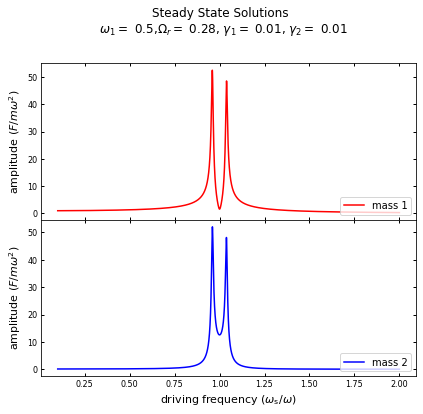

In [242]:
# Define parameters
omega1 = 0.96
Foverm = 1
t1 = 0
delt = 0
tF = 28
deltF = 81
gamma1 = 0.01
gamma2 = 0.01
OmegaR = np.sqrt(1-omega1**2)

# Define different omegas values
drives = np.linspace(0.1,2,20000)
# Numpy Func
x10 = np.frompyfunc(x10single,5,2)
x20 = np.frompyfunc(x20single,5,2)

# get the amplitude and phase for each mass
x1sA,x1sph = x10(drives,omega1,gamma1,gamma2,Foverm)
x2sA,x2sph = x20(drives,omega1,gamma1,gamma2,Foverm)      

# ******* Plotting ******************************* 

# some extra beautification
# overall plot font
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 8}
matplotlib.rc('font', **font)

f1 = plt.figure(1,figsize = (6,6))
plt.clf()
gs = gridspec.GridSpec(2,1,top = 0.85,left = 0.08,right = 0.95,hspace = 0,wspace = 0)
f1.suptitle('Steady State Solutions \n $\omega_1 =$ {:.2},$\Omega_r = $ {:.2}, $\gamma_1 =$ {:.2}, $\gamma_2 =$ {:.2}'.format(omega0,OmegaR,gamma1,gamma2),fontsize =12)

# x1, amplitude
ax1 = plt.subplot(gs[0])
ax1.plot(drives, x1sA, 'r-',label='mass 1')
ax1.legend(loc=4,prop={'size':10})
#ax1.set_title('Mass 1')
ax1.tick_params(axis = 'both',width=1, length = 3,direction = 'in',top='true',right = 'true')
ax1.set_xticklabels([])
ax1.set_ylabel(r'amplitude ($F/m\omega^2$)',fontsize=11)


# x2 amplitude
ax2 = plt.subplot(gs[1])
ax2.plot(drives, x2sA, 'b-',label='mass 2')
ax2.legend(loc=4,prop={'size':10})
#ax2.set_title('Mass 2')
ax2.tick_params(axis = 'both',width=1, length = 3,direction = 'in',top='true',right = 'true')
#ax2.set_yticklabels([])
#ax2.set_xticklabels([])
ax2.set_ylabel(r'amplitude ($F/m\omega^2$)',fontsize=11)
ax2.tick_params(axis = 'both',width=1, length = 3,direction = 'in',top='true',right = 'true')
ax2.set_xlabel(r'driving frequency ($\omega_{\rm s}/\omega$)',fontsize = 11)

Text(0, 0.5, 'signal')

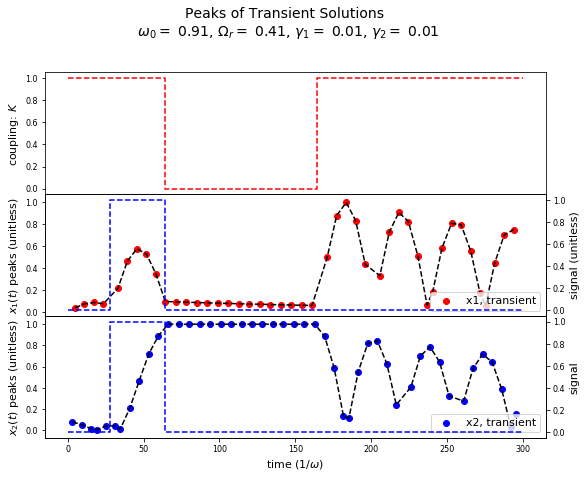

In [265]:
# Define parameters and ICs
omega0 = 0.91
Foverm = 1
t1 = 64
delt = 100
tF = 28
deltF = 36
gamma1 = 0.01
gamma2 = 0.01
OmegaR = np.sqrt(1-omega0**2)

# Define parameters and ICs
params = [omega0,gamma1,gamma2,Foverm,1]
#y0 = [0+0j,0+0j,0+0j,0+0j]
y0 = [0,-Foverm,0,0] # without complex drive, use real ICs
t_evaluate = np.linspace(0,300,10000)
# Solve coupled ODEs
sol = sci.solve_ivp(lambda t,y: CoupledMassODE(t,y,params,t1,delt,tF,deltF),(0,300),y0,t_eval=t_evaluate)

# get the peaks
diff = sol.y[0]-sol.y[1]

x1_signal,x1_chars = scisignal.find_peaks(sol.y[0],height=0)
x2_signal,x2_chars = scisignal.find_peaks(sol.y[1],height=0)
x1x2_signal,x1x2_chars = scisignal.find_peaks(diff)

x1_peaks = sol.y[0][x1_signal]
x2_peaks = sol.y[1][x2_signal]
x1x2_peaks = diff[x1x2_signal]

x1_times = sol.t[x1_signal]
x2_times = sol.t[x2_signal]
x1x2_times = diff[x1x2_signal]


#normalize the amplitude :)
max_x1 = max(x1_peaks)
max_x2 = max(x2_peaks)
max_x1x2 = max(x1x2_peaks)

x1_peaks = x1_peaks*(1/max_x1)
x2_peaks = x2_peaks*(1/max_x2)
x1x2_peaks = x1x2_peaks*(1/max_x1x2)

# We also want to see on the plot of transient solutions the coupling strength 
times = np.array([0,t1,t1+delt,np.max(sol.t)])
Kx = np.array([1,1,0,1])

# We also want to see on the plot the force:
timesF = np.array([0,tF,tF+deltF,np.max(sol.t)])
F = np.array([0,0,1,0])

# Plots
# Transient states
f2 = plt.figure(2,figsize = (8,7))
plt.clf()
f2.suptitle('Peaks of Transient Solutions \n $\omega_0 =$ {:.2}, $\Omega_r = $ {:.2}, $\gamma_1 =$ {:.2}, $\gamma_2 =$ {:.2}'.format(omega0,OmegaR,gamma1,gamma2),fontsize =14)
gs1 = gridspec.GridSpec(3,1,top = 0.85,left = 0.08,right = 0.95,hspace = 0,wspace = 0)

# Coupling Strength
ax3 = plt.subplot(gs1[0])
ax3.step(times,Kx,'r--',label='coupling strength')
ax3.set_ylabel(r'coupling: $K$',fontsize=11)

# Driven mass position
ax1 = plt.subplot(gs1[1])
#ax1.plot(times,x1ss,'k-',alpha = 0.5,label = 'x1, steady state')
ax1.scatter(x1_times,x1_peaks,c='r',label = 'x1, transient')
ax1.plot(x1_times,x1_peaks,'k--')
ax1.legend(loc=4,prop={'size':11})
ax1.set_ylabel(r'$x_1(t)$ peaks (unitless)',fontsize=11)

# Passive mass position
ax2 = plt.subplot(gs1[2])
#ax2.plot(times,x2ss,'k-',alpha = 0.5,label = 'x2, steady state')
ax2.scatter(x2_times,x2_peaks,c='b',label = 'x2, transient')
ax2.plot(x2_times,x2_peaks,'k--')
ax2.legend(loc =4,prop={'size':11})
ax2.set_ylabel(r'$x_2(t)$ peaks (unitless)',fontsize=11)
ax2.set_xlabel(r'time ($1/\omega$)',fontsize=11)

# Signal strength
ax4 = ax1.twinx()
#ax4 = plt.subplot(gs1[3])
ax4.step(timesF,F,'b--',label='signal')
ax4.set_ylabel(r'signal (unitless)',fontsize=11)

# Signal strength
ax5 = ax2.twinx()
#ax4 = plt.subplot(gs1[3])
ax5.step(timesF,F,'b--',label='signal')
ax5.set_ylabel(r'signal',fontsize=11)